# Final Report Group 8

## Statistically Inferring the Difference in Proportions of Break and Enter Type Crimes Between Two Vancouver Neighborhoods: Shaughnessy and Oakridge

### Introduction

Over the last 20 years, the population of Vancouver has dramatically increased, and in accordance, the number of crimes within city neighborhoods has increased as well. In this project, an analysis of the proportion of types of crimes between two neighborhoods was conducted to find if there was a statistically significant difference. According to a study conducted at Simon Fraser University, post-pandemic reports by the Vancouver Police Department (VPD) saw an increase in crimes in poorer areas while richer areas either remained the same or witnessed a small increase in theft-related crimes. In addition to this study, another poll conducted in June 2022 reported that 3 in 5 British Columbians say crime is rising and public safety is decreasing. These research papers identified an interest for our group to investigate how the proportion of crimes varies among two neighborhoods, considering there is pre-existing research on these topics. In addition, if we find a statistically significant difference between these two neighborhoods, we are curious to see if they agree with the literature on this topic. 

Note that the estimator used in this project is a difference in proportions calculated from a data set containing the types of crime occuring in various neighbourhoods throughout Vancouver. In this case, a scale parameter (i.e. standard deviation, inter-quartile range, etc.) cannot be hypothesized because the raw data is not composed of numerical values. 

### Preliminary Results

In [4]:
library(datateachr)
library(infer)
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [5]:
# This data frame contains crime data from the year 2022 for a multitude of different neighborboods
all_crime <- read.csv("https://github.com/nehamenon704/stat201project/raw/main/crimedata_csv_AllNeighbourhoods_2022.csv")
head(all_crime)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Break and Enter Commercial,2022,1,3,16,19,10XX ALBERNI ST,West End,491036.1,5459146
2,Break and Enter Commercial,2022,6,17,5,16,10XX ALBERNI ST,West End,491067.3,5459115
3,Break and Enter Commercial,2022,3,15,5,14,10XX ALBERNI ST,West End,491102.2,5459092
4,Break and Enter Commercial,2022,3,19,6,42,10XX ALBERNI ST,West End,491102.2,5459092
5,Break and Enter Commercial,2022,2,23,23,0,10XX BALFOUR AVE,Shaughnessy,490699.8,5455444
6,Break and Enter Commercial,2022,2,25,10,15,10XX BALFOUR AVE,Shaughnessy,490699.8,5455444


The full data set gets selected for neighbourhood and crime type for the year of 2022. There are two types of break and enter crimes (commercial and residential/other) that get combined into a general category of "Break and Enter". This will help us in our analysis. 

In [6]:
crime <- all_crime %>%
    select(TYPE, NEIGHBOURHOOD) 
crime$TYPE <- replace(crime$TYPE, crime$TYPE == 'Break and Enter Commercial', 'Break and Enter')
crime$TYPE <- replace(crime$TYPE, crime$TYPE == 'Break and Enter Residential/Other', 'Break and Enter')
head(crime)

,TYPE,NEIGHBOURHOOD
,<chr>,<chr>
1,Break and Enter,West End
2,Break and Enter,West End
3,Break and Enter,West End
4,Break and Enter,West End
5,Break and Enter,Shaughnessy
6,Break and Enter,Shaughnessy


### Outline of Methods

To determine if there is a statistically significant difference between these two groups, we have decided to perform a two-tailed hypothesis test to determine if the proportion of B&Es in Oakridge is different from the proportion of B&Es in Shaughnessy. We will perform our test with α = 0.05 (5% significance level) and will produce a confidence interval for the difference in proportions using the same significance level. We will employ two different methods for our hypothesis test - using bootstrapping (simulation based) and using the Central Limit Theorem (theory based).


### Simulation-Based Method

The case to be considered is:

- $H_0: p_1 - p_2 = 0$ vs $H_1: p_1 - p_2 \neq 0$

Where $p_1$ and $p_2$ are the proportions of break and enters in regards to all crimes in Shaughnessy and Oakridge respectively.

The following cell produces the silulation-based null distribution of the difference in proportion of break and enters between Shaughnessy and Oakridge by using 2000 resamples with replacement. This is aproximating what the sampling variation would be in a world where there is no difference in the proportions of break and enters between the two neighbourhoods. The vertical red line is the observed test statistic calculated from our 2022 sample. The shaded red region indicates the how often the null test was even more pronounced than the observed test statistic.

The p-value is:  0.3128

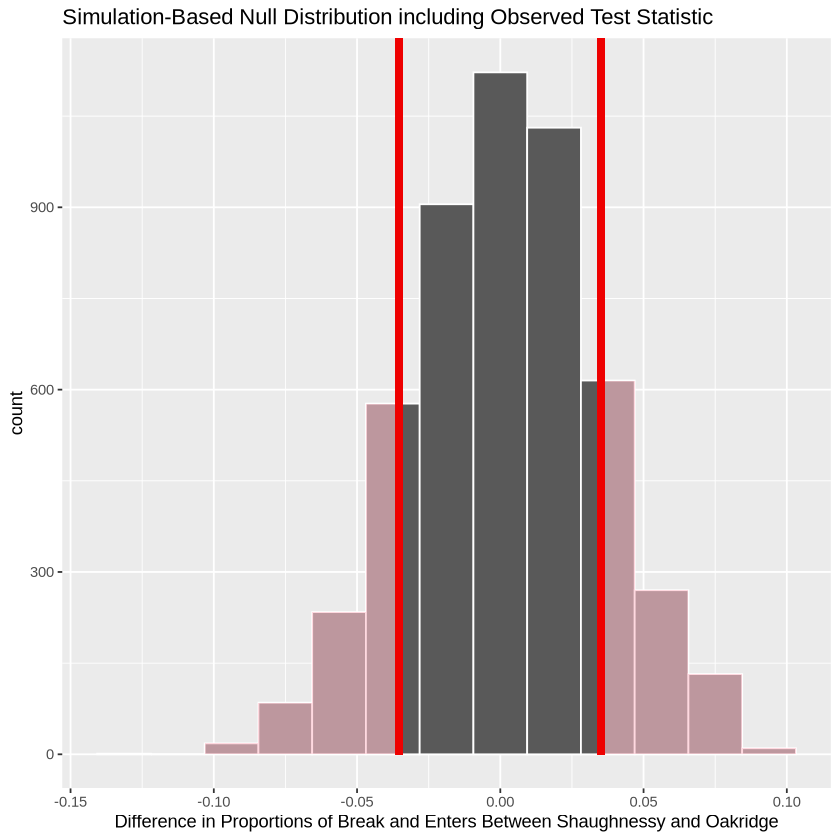

In [13]:

#To ensure reproducibility of our results 
set.seed(222)

# Now to construct the actual confidence interval:

#This will filter the crime dataset to only include Shaugnessy and Oakridge as neighborhoods
crime_two_nh <- crime %>%
    filter(NEIGHBOURHOOD %in% c('Shaughnessy', 'Oakridge'))

# the infer package 'success'can only be used if the response variable only has two levels
# This line replaces all the other types of crime besides 'Break and Enter' to be 'Other Crimes'
crime_two_nh$TYPE <- replace(crime_two_nh$TYPE, crime_two_nh$TYPE != 'Break and Enter', 'Other Crimes')

# The actual observed difference in proportions of our sample
obs_diff_props <- crime_two_nh %>%
    specify(TYPE ~ NEIGHBOURHOOD, success = 'Break and Enter') %>%
    calculate(stat = 'diff in props', order = c('Shaughnessy', 'Oakridge'))

#This generates a bootstrap distribution under the null hypothesis, by taking 5000 resamples, and calculating the difference in proportions
null_distribution <- crime_two_nh %>%
    specify(TYPE ~ NEIGHBOURHOOD, success = 'Break and Enter') %>%
    hypothesise(null = 'independence') %>%
    generate(reps = 5000, type = 'permute') %>%
    calculate(stat = 'diff in props', order = c('Shaughnessy', 'Oakridge'))
        
# We are visualizing our null distribution, and marking our observed difference between the proportions and shading our p-value
visualize(null_distribution, bins = 13) +
    shade_p_value(obs_stat = obs_diff_props, direction = 'right') +
    shade_p_value(obs_stat=-obs_diff_props, direction="left")+
    labs(title = 'Simulation-Based Null Distribution including Observed Test Statistic', 
         x = 'Difference in Proportions of Break and Enters Between Shaughnessy and Oakridge')

p_value <- null_distribution %>%
    get_p_value(obs_stat = obs_diff_props, direction = 'two.sided')|>
    as.numeric()

cat("The p-value is: ",p_value)


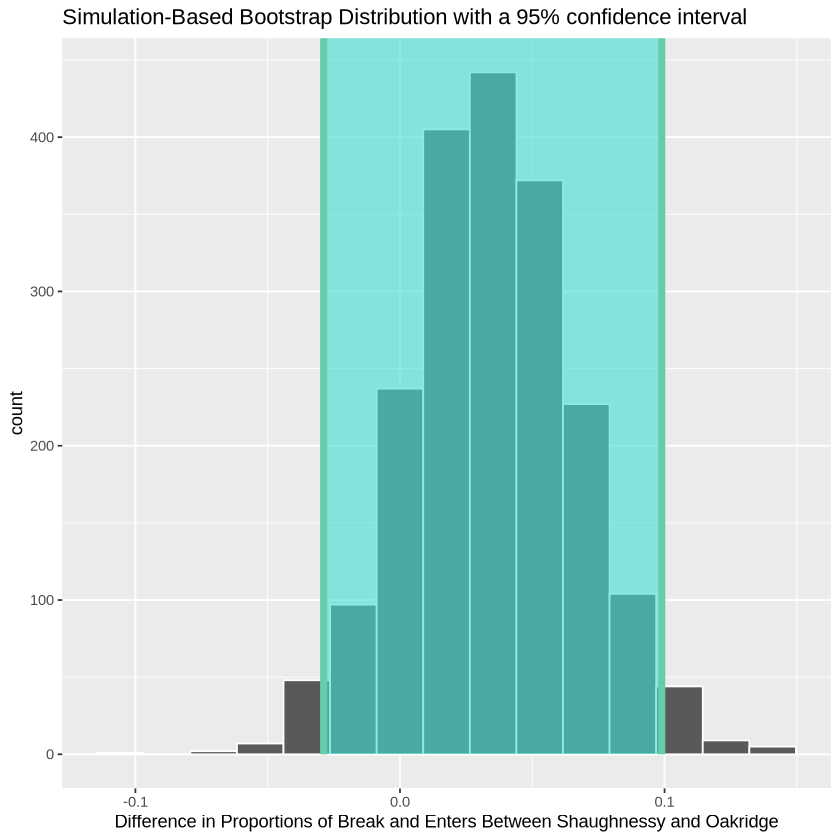

In [8]:
bootstrap_distribution <- crime_two_nh %>%
    specify(TYPE ~ NEIGHBOURHOOD, success = 'Break and Enter') %>%
    generate(reps = 2000, type = 'bootstrap') %>%
    calculate(stat = 'diff in props', order = c('Shaughnessy', 'Oakridge'))

percentile_ci <- bootstrap_distribution %>%
    get_ci(level = 0.95, type = 'percentile')

visualize(bootstrap_distribution) +
    shade_confidence_interval(endpoints = percentile_ci) +
    labs(title = 'Simulation-Based Bootstrap Distribution with a 95% confidence interval', 
         x = 'Difference in Proportions of Break and Enters Between Shaughnessy and Oakridge')

#### Results of Simulation Based Method

We are 95% confident that the true difference in proportion of break and enter type crimes between the neighbourhoods of Shaughnessy and Oakridge are between the values of -0.027 and 0.1. 

With a 5% significance level, we do not reject the null-hypothesis that the proportion of break and enters between the Shaughnessy and Oakridge neighbourhoods are any different in 2022, since our p-value is greater than 0.05.


### Theory-Based Method

Once again, the case we are considering is:

- $H_0: p_1 - p_2 = 0$ vs $H_1: p_1 - p_2 \neq 0$

In the next section, we will be producing a confidence interval by using the Central Limit Theorem. In order to use this theoretical method, several conditions need to be met by our data. The sample must be big enough, the sample must have been taken in an independent fashion, and the estimator being used needs to be a sum of random components. As indicated below, there are 665 observations in the data set; therefore, it is large enough. This data was extracted from the PRIME BC Police Records Management System (RMS), which indicates that it was likely gathered in an independent fashion. Lastly, the estimator being used is the difference in proportions, which is indeed a sum of random components.

In [15]:
cat('The number of observations in this data set is: ',nrow(crime_two_nh))

The number of observations in this data set is:  665

Since we are testing the difference in proportion between two independent populations, our test statistic is:

$$
Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}
$$
where $\hat{p}_1$ and $\hat{p}_2$ are the sample proportions of break and enter type crimes in Shaughnessy and Oakridge, respectively; $n$ is the sample size; and $\hat{p}$ is the pooled proportion, given by: 

$$\hat{p} = \frac{n_1\hat{p}_1+n_2\hat{p}_2}{n_1+n_2}$$

In [16]:
summary <- crime_two_nh %>%
    group_by(NEIGHBOURHOOD) %>%
    summarize(n = n(),
              prop = mean(TYPE == 'Break and Enter'))
summary

NEIGHBOURHOOD,n,prop
<chr>,<int>,<dbl>
Oakridge,368,0.2038043
Shaughnessy,297,0.2390572


In [17]:
n1 <- summary$n[2]
n2 <- summary$n[1]
p1 <- summary$prop[2]
p2 <- summary$prop[1]

p_hat <- (n1*p1 + n2*p2) / (n1 + n2)

# Our test statistic
Z <- (p1 - p2) / sqrt(p_hat*(1 - p_hat)*(1/n1 + 1/n2))

# p-value
p <- 2*pnorm(Z, lower.tail = FALSE)
cat("the p-value is: ",p)

the p-value is:  0.274916

In [18]:
#To calculate confidence intervals based on theory based methods: 

moe<- 1.96 * sqrt((p1*(1-p1)/n1)+ (p2*(1-p2)/n2))

CI<- tibble(lower_ci= (p1-p2) - moe, upper_ci= (p1-p2) +moe)
CI

lower_ci,upper_ci
<dbl>,<dbl>
-0.02836213,0.09886792


To check that the confidence interval boundaries are correct, and confirm the p-value we calculated above, we can let R do the work for us and utilize the prop.test function.

In [20]:
t_test <- tidy(
    prop.test(x =c(p1*n1, p2*n2),
              n = c(n1, n2),
              correct = FALSE))
t_test

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.2390572,0.2038043,1.192052,0.274916,1,-0.02836096,0.09886675,2-sample test for equality of proportions without continuity correction,two.sided


Our results obtained manually are extremely close to the results obtained using the prop.test function, matching up to 5 decimal places.

#### Results of Theory Based Method
The p-value and lower and upper values for the confidence interval are nearly the same between the simulation based and theory based methods. 

We once again cannot reject the null-hypothesis that there is a statistically significant difference between the proportions of break and enters between Shaughnessy and Oakridge with a significance level of 5%. 

Based on these results, we are 95% confident that the true difference in proportions between the two neighbourhoods lies between the values of -0.0284 and 0.0989. 

### Discussion 

Our study aimed to determine if there is a statistically significant difference in the proportion of break and enter type crimes in the Shaughnessy and Oakridge neighbourhoods. The p-values obtained were 0.31 and 0.27 from a dual-approach method that used both simulation-based and theory-based methods respectively. With a significance level of 5%, we do not have sufficient evidence to reject our null hypothesis that there is no difference between the proportions of break and enter type crimes between the two neighbourhoods. However, the clear difference between the p-values obtained from these two methods calls for a more in-depth look.

The difference could suggest that one or more of the assumptions underpinning the Central Limit Theorem (CLT), which our theory-based method relies upon, may not be fully met. For the CLT to be applicable, certain conditions must be satisfied, such as the assumption of independence among observations. The discrepancy in p-values might be attributed to a breach in this conditions. This would be evident if the crime rates in one area influenced those in another.

Regardless, our finding challenges the notion that such criminal behaviours can be straightforwardly linked to socio-economic factors or other commonly cited determinants.

In conclusion, our research does not support the presence of a statistically significant difference in proportions of break and enter type crimes between the Shaughnessy and Oakridge neighbourhoods for the year of 2022. The statistical results obtained by this study should be interpreted cautiously, as the significance level was chosen somewhat arbitrarily. By choosing such a low significance level, we are increasing the risk of making type-2 error (i.e. false negative). This emphasizes the importance of a comprehensive approach in analyzing urban crime dynamics.

The minor differences between the simulation-based and theory-based results underscore the critical role of thorough and rigorous statistical analysis in criminological research. Future studies should not only broaden the range of variables examined but also employ an extensive array of statistical methods to ensure the robustness of their findings. For example, if we observe that the proportion of B&Es in Shaughnessy is higher, the police can choose to assign more police officers to Shaughnessy and fewer to Oakridge. Furthermore, more surveillance resources can be dispensed for this neighbourhood to ensure no breaking and entering occurs. Knowing the difference in proportions of any crime can help in policy-making and resource allocation in those neighbourhoods. Our analysis can also lead to further questions, such as:
- What causes the proportion of a certain type of crime (such as B&Es) to be higher in one neighbourhood than another?
- How much has the proportion of a certain type of crime (such as B&Es) increased in the last decade?
- What structural and institutional change can be implemented to reduce crime in specific neighbourhoods?

An in-depth exploration into the multitude of factors influencing urban crime, including socio-economic, spatial, and temporal elements, could yield crucial insights. Such insights are important for developing effective public safety strategies and the optimal allocation of resources for crime prevention and community well-being.

#### References

Canseco, M. (2023, May 24). Almost three-in-five British Columbians say crime is rising. Research Co. https://researchco.ca/2023/05/24/crime-bc-3/ 

CBC/Radio Canada. (2022a, January 23). New study shows higher incidence of violent crime in poor Vancouver neighbourhoods, theft in wealthier ones | CBC news. CBCnews. https://www.cbc.ca/news/canada/british-columbia/sfu-study-vancouver-crime-impacts-1.6323902 